In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_loop_active
from process_models import simulate_ricker
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Summary network for the Ricker model
<p>We use an LSTM for the observed time-series data.</p>

In [11]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=32, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

# Initialization 

In [5]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
param_names = ['r', 'sigma', 'phi']
theta_dim = 3
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

## Create a test set

In [17]:
X_test, theta_test = simulate_ricker(n_test, t_obs_min=500, t_obs_max=500)

## Create networks

In [12]:
summary_net = SequenceNetwork(h_lstm_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Checkpoint manager

In [13]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/ricker', max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Plot performance of untrained networks

Instructions for updating:
Colocations handled automatically by placer.


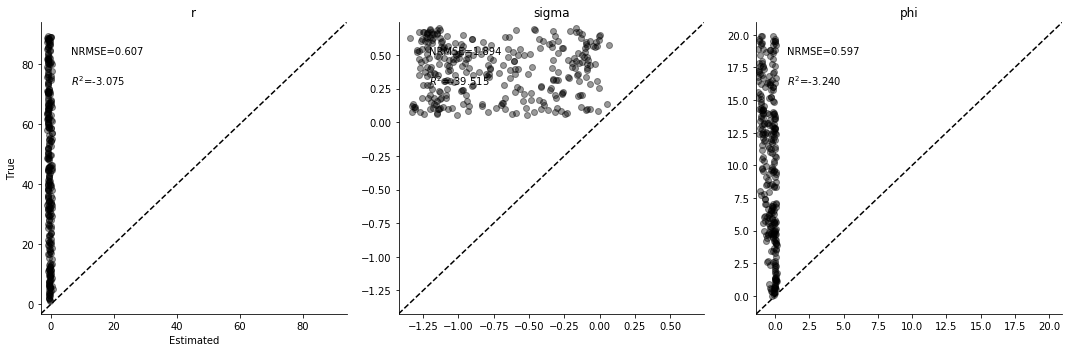

In [8]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(15, 5))

# Train the model

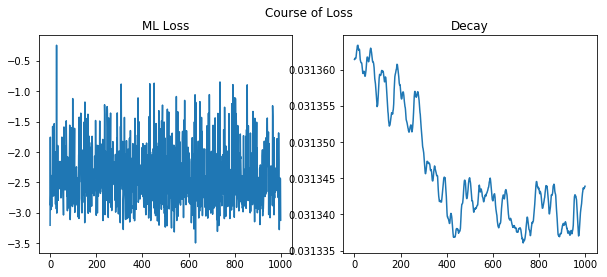

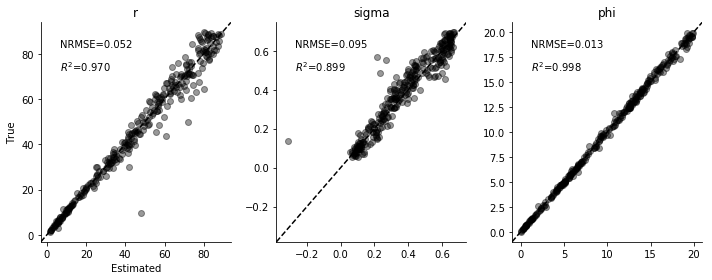

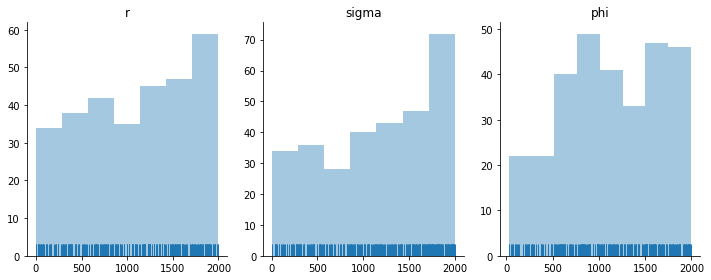

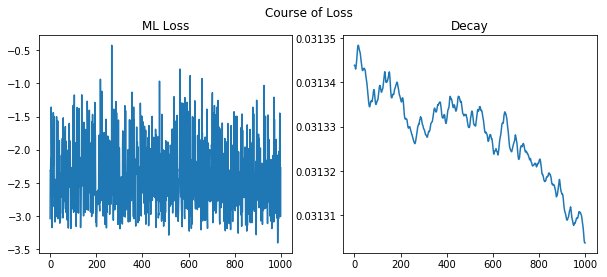

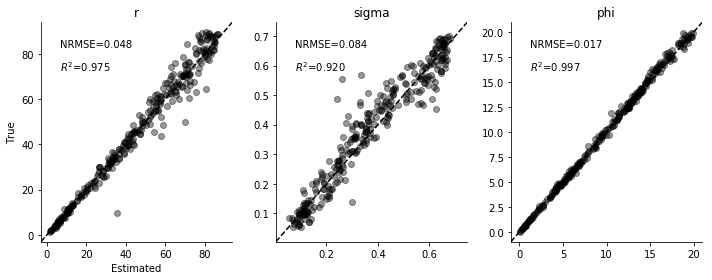

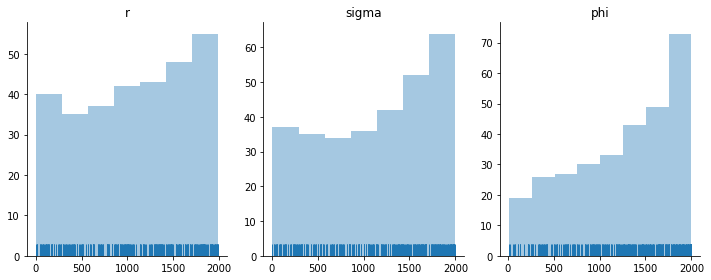

KeyboardInterrupt: 

In [16]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_loop_active(model, optimizer, simulate_ricker, iterations_per_epoch, 
                            batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                            global_step=global_step, ckpt_name='Ricker_{}'.format(ep))
        
        # Plot stuff
        plot_losses(losses, figsize=(10, 4))
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 4))
        plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))
        
        # Store checkpoint
        manager.save()

# Evaluate the trained model

## Posterior means (recovery)

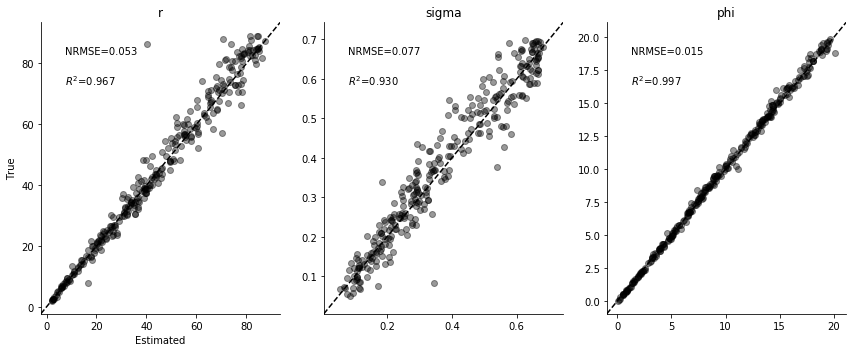

In [18]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(12, 5))

## Full posterior (visual inspection)

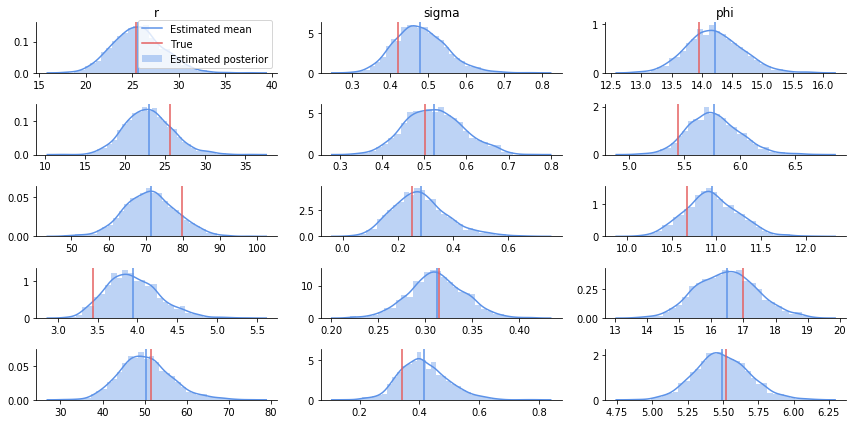

In [19]:
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        n_test=5, data_generator=simulate_ricker, figsize=(12, 6))

## Simulation-based calibration

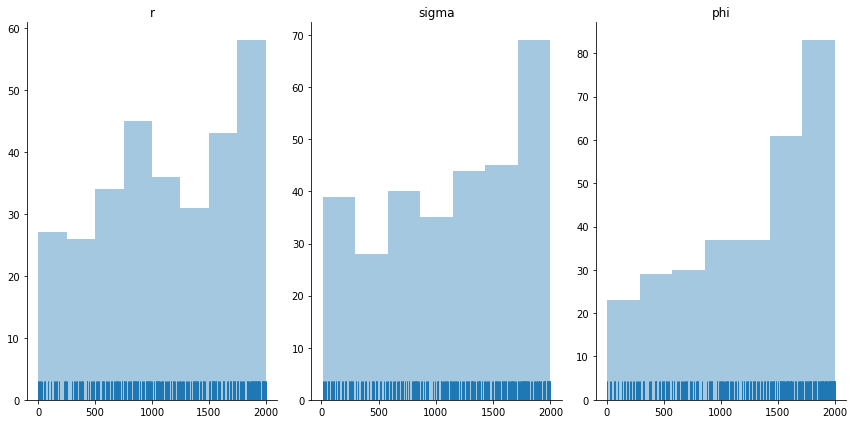

In [20]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(12, 6))